# **Bert + LSTM**

In [1]:
!pip install -q transformers torch scikit-learn tqdm textattack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 46.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 44.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s et

In [2]:
import pandas as pd
import numpy as np
import torch
import random
import re
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from textattack.augmentation import EasyDataAugmenter


textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw to /usr/share/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-08-02 00:00:48.665869: E external/local_xla/xla/stream_executor/cuda/cuda_

In [3]:
df = pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv')
df = df[['tweet', 'class']].dropna()
label_map = {0: 1, 1: 0, 2: 2}  # Hate=1, Offensive=0, Neutral=2
df['label'] = df['class'].map(label_map)

def clean_text(text):
    text = re.sub(r"http\S+", "", str(text))
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['tweet'] = df['tweet'].apply(clean_text)
print("Original class counts:", dict(df['label'].value_counts()))


Original class counts: {0: 19190, 2: 4163, 1: 1430}


In [4]:
hate_df = df[df['label'] == 1]
neutral_df = df[df['label'] == 2]
offensive_df = df[df['label'] == 0]

target_size = max(len(hate_df), len(neutral_df), len(offensive_df))
print("Target samples per class:", target_size)

augmenter = EasyDataAugmenter()

def augment_class(df_class, target_size, label):
    texts = df_class['tweet'].tolist()
    aug_texts = []
    needed = target_size - len(texts)
    if needed > 0:
        per_text = max(1, int(np.ceil(needed / len(texts))))
        # Loop through and augment
        with tqdm(total=needed, desc=f"Augmenting label {label}") as pbar:
            i = 0
            while len(aug_texts) < needed:
                t = texts[i % len(texts)]
                try:
                    aug = augmenter.augment(t)
                except Exception:
                    aug = []
                if aug and aug[0].strip() and aug[0] != t:
                    aug_texts.append(aug[0])
                    pbar.update(1)
                i += 1
    all_texts = texts + aug_texts[:needed]
    return pd.DataFrame({'tweet': all_texts, 'label': [label] * target_size})

hate_bal = augment_class(hate_df, target_size, 1)
neutral_bal = augment_class(neutral_df, target_size, 2)
offensive_bal = offensive_df.sample(target_size, replace=True, random_state=42).reset_index(drop=True)
offensive_bal = pd.DataFrame({'tweet': offensive_bal['tweet'], 'label': [0] * target_size})

# Combine and shuffle
final_df = pd.concat([offensive_bal, hate_bal, neutral_bal]).sample(frac=1, random_state=42).reset_index(drop=True)
print("Balanced class counts:", dict(final_df['label'].value_counts()))


Target samples per class: 19190


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Augmenting label 2: 100%|██████████| 15027/15027 [07:40<00:00, 32.61it/s]

Balanced class counts: {1: 19190, 2: 19190, 0: 19190}


In [5]:
X = final_df['tweet'].tolist()
y = final_df['label'].tolist()
train_texts, val_texts, train_labels, val_labels = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [6]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")
max_len = 64

def encode_texts(texts, tokenizer, max_len=64):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

class BertLSTMDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        encodings = encode_texts(texts, tokenizer, max_len)
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
        self.labels = torch.tensor(labels)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

train_dataset = BertLSTMDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = BertLSTMDataset(val_texts, val_labels, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [7]:
class BertLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name="GroNLP/hateBERT", lstm_hidden_size=128, lstm_layers=1, num_classes=3, freeze_bert=True):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(lstm_hidden_size * 4, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.set_grad_enabled(not self.bert.embeddings.word_embeddings.weight.requires_grad):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state
        lstm_out, _ = self.lstm(x)
        avg_pool = torch.mean(lstm_out, 1)
        max_pool, _ = torch.max(lstm_out, 1)
        pooled = torch.cat((avg_pool, max_pool), 1)
        out = self.dropout(pooled)
        logits = self.classifier(out)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertLSTMClassifier(freeze_bert=True).to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 15

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss, train_preds, train_true = 0, [], []
    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_preds += preds.cpu().numpy().tolist()
        train_true += labels.cpu().numpy().tolist()
    train_f1 = f1_score(train_true, train_preds, average='macro')
    train_acc = accuracy_score(train_true, train_preds)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch+1} Train Loss: {train_losses[-1]:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

    # Validation
    model.eval()
    val_loss, val_preds, val_true = 0, [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_preds += preds.cpu().numpy().tolist()
            val_true += labels.cpu().numpy().tolist()
    val_f1 = f1_score(val_true, val_preds, average='macro')
    val_acc = accuracy_score(val_true, val_preds)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1} Val Loss: {val_losses[-1]:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
    print(classification_report(val_true, val_preds, digits=4, target_names=["Offensive", "Hate", "Neutral"]))

print("=== Training Complete ===")


Train Epoch 1: 100%|██████████| 2879/2879 [02:49<00:00, 16.97it/s]


Epoch 1 Train Loss: 0.5311 | Acc: 0.7820 | F1: 0.7806


Val Epoch 1: 100%|██████████| 360/360 [00:43<00:00,  8.26it/s]


Epoch 1 Val Loss: 0.4238 | Acc: 0.8324 | F1: 0.8332
              precision    recall  f1-score   support

   Offensive     0.8081    0.8317    0.8197      3838
        Hate     0.7802    0.8072    0.7934      3838
     Neutral     0.9168    0.8583    0.8866      3838

    accuracy                         0.8324     11514
   macro avg     0.8350    0.8324    0.8332     11514
weighted avg     0.8350    0.8324    0.8332     11514



Train Epoch 2: 100%|██████████| 2879/2879 [03:02<00:00, 15.80it/s]


Epoch 2 Train Loss: 0.3699 | Acc: 0.8557 | F1: 0.8550


Val Epoch 2: 100%|██████████| 360/360 [00:43<00:00,  8.20it/s]


Epoch 2 Val Loss: 0.3165 | Acc: 0.8816 | F1: 0.8817
              precision    recall  f1-score   support

   Offensive     0.8376    0.8830    0.8597      3838
        Hate     0.8792    0.8398    0.8590      3838
     Neutral     0.9308    0.9221    0.9264      3838

    accuracy                         0.8816     11514
   macro avg     0.8825    0.8816    0.8817     11514
weighted avg     0.8825    0.8816    0.8817     11514



Train Epoch 3: 100%|██████████| 2879/2879 [03:01<00:00, 15.83it/s]


Epoch 3 Train Loss: 0.2730 | Acc: 0.8993 | F1: 0.8990


Val Epoch 3: 100%|██████████| 360/360 [00:43<00:00,  8.20it/s]


Epoch 3 Val Loss: 0.2436 | Acc: 0.9105 | F1: 0.9101
              precision    recall  f1-score   support

   Offensive     0.8812    0.9010    0.8910      3838
        Hate     0.9205    0.8632    0.8910      3838
     Neutral     0.9301    0.9672    0.9483      3838

    accuracy                         0.9105     11514
   macro avg     0.9106    0.9105    0.9101     11514
weighted avg     0.9106    0.9105    0.9101     11514



Train Epoch 4: 100%|██████████| 2879/2879 [03:02<00:00, 15.82it/s]


Epoch 4 Train Loss: 0.2039 | Acc: 0.9265 | F1: 0.9263


Val Epoch 4: 100%|██████████| 360/360 [00:43<00:00,  8.21it/s]


Epoch 4 Val Loss: 0.1790 | Acc: 0.9399 | F1: 0.9398
              precision    recall  f1-score   support

   Offensive     0.9494    0.8999    0.9240      3838
        Hate     0.9157    0.9588    0.9367      3838
     Neutral     0.9562    0.9609    0.9585      3838

    accuracy                         0.9399     11514
   macro avg     0.9404    0.9399    0.9398     11514
weighted avg     0.9404    0.9399    0.9398     11514



Train Epoch 5: 100%|██████████| 2879/2879 [03:01<00:00, 15.82it/s]


Epoch 5 Train Loss: 0.1571 | Acc: 0.9449 | F1: 0.9448


Val Epoch 5: 100%|██████████| 360/360 [00:43<00:00,  8.20it/s]


Epoch 5 Val Loss: 0.1643 | Acc: 0.9446 | F1: 0.9446
              precision    recall  f1-score   support

   Offensive     0.9166    0.9448    0.9305      3838
        Hate     0.9569    0.9200    0.9381      3838
     Neutral     0.9615    0.9690    0.9652      3838

    accuracy                         0.9446     11514
   macro avg     0.9450    0.9446    0.9446     11514
weighted avg     0.9450    0.9446    0.9446     11514



Train Epoch 6: 100%|██████████| 2879/2879 [03:02<00:00, 15.80it/s]


Epoch 6 Train Loss: 0.1290 | Acc: 0.9547 | F1: 0.9546


Val Epoch 6: 100%|██████████| 360/360 [00:44<00:00,  8.17it/s]


Epoch 6 Val Loss: 0.1217 | Acc: 0.9599 | F1: 0.9598
              precision    recall  f1-score   support

   Offensive     0.9612    0.9367    0.9488      3838
        Hate     0.9625    0.9552    0.9588      3838
     Neutral     0.9561    0.9878    0.9717      3838

    accuracy                         0.9599     11514
   macro avg     0.9599    0.9599    0.9598     11514
weighted avg     0.9599    0.9599    0.9598     11514



Train Epoch 7: 100%|██████████| 2879/2879 [03:02<00:00, 15.78it/s]


Epoch 7 Train Loss: 0.1057 | Acc: 0.9632 | F1: 0.9632


Val Epoch 7: 100%|██████████| 360/360 [00:44<00:00,  8.17it/s]


Epoch 7 Val Loss: 0.1070 | Acc: 0.9639 | F1: 0.9638
              precision    recall  f1-score   support

   Offensive     0.9615    0.9442    0.9528      3838
        Hate     0.9539    0.9768    0.9652      3838
     Neutral     0.9764    0.9706    0.9735      3838

    accuracy                         0.9639     11514
   macro avg     0.9640    0.9639    0.9638     11514
weighted avg     0.9640    0.9639    0.9638     11514



Train Epoch 8: 100%|██████████| 2879/2879 [03:02<00:00, 15.78it/s]


Epoch 8 Train Loss: 0.0874 | Acc: 0.9696 | F1: 0.9695


Val Epoch 8: 100%|██████████| 360/360 [00:44<00:00,  8.16it/s]


Epoch 8 Val Loss: 0.0941 | Acc: 0.9693 | F1: 0.9693
              precision    recall  f1-score   support

   Offensive     0.9606    0.9591    0.9598      3838
        Hate     0.9682    0.9745    0.9713      3838
     Neutral     0.9793    0.9745    0.9769      3838

    accuracy                         0.9693     11514
   macro avg     0.9694    0.9693    0.9693     11514
weighted avg     0.9694    0.9693    0.9693     11514



Train Epoch 9: 100%|██████████| 2879/2879 [03:02<00:00, 15.76it/s]


Epoch 9 Train Loss: 0.0745 | Acc: 0.9743 | F1: 0.9742


Val Epoch 9: 100%|██████████| 360/360 [00:44<00:00,  8.16it/s]


Epoch 9 Val Loss: 0.0915 | Acc: 0.9715 | F1: 0.9715
              precision    recall  f1-score   support

   Offensive     0.9677    0.9612    0.9644      3838
        Hate     0.9677    0.9758    0.9717      3838
     Neutral     0.9791    0.9776    0.9784      3838

    accuracy                         0.9715     11514
   macro avg     0.9715    0.9715    0.9715     11514
weighted avg     0.9715    0.9715    0.9715     11514



Train Epoch 10: 100%|██████████| 2879/2879 [03:03<00:00, 15.71it/s]


Epoch 10 Train Loss: 0.0646 | Acc: 0.9780 | F1: 0.9779


Val Epoch 10: 100%|██████████| 360/360 [00:44<00:00,  8.10it/s]


Epoch 10 Val Loss: 0.0947 | Acc: 0.9706 | F1: 0.9705
              precision    recall  f1-score   support

   Offensive     0.9772    0.9479    0.9623      3838
        Hate     0.9570    0.9849    0.9707      3838
     Neutral     0.9781    0.9789    0.9785      3838

    accuracy                         0.9706     11514
   macro avg     0.9708    0.9706    0.9705     11514
weighted avg     0.9708    0.9706    0.9705     11514



Train Epoch 11: 100%|██████████| 2879/2879 [03:02<00:00, 15.75it/s]


Epoch 11 Train Loss: 0.0562 | Acc: 0.9804 | F1: 0.9803


Val Epoch 11: 100%|██████████| 360/360 [00:44<00:00,  8.16it/s]


Epoch 11 Val Loss: 0.1175 | Acc: 0.9596 | F1: 0.9596
              precision    recall  f1-score   support

   Offensive     0.9502    0.9492    0.9497      3838
        Hate     0.9438    0.9888    0.9658      3838
     Neutral     0.9869    0.9409    0.9633      3838

    accuracy                         0.9596     11514
   macro avg     0.9603    0.9596    0.9596     11514
weighted avg     0.9603    0.9596    0.9596     11514



Train Epoch 12: 100%|██████████| 2879/2879 [03:02<00:00, 15.77it/s]


Epoch 12 Train Loss: 0.0476 | Acc: 0.9834 | F1: 0.9834


Val Epoch 12: 100%|██████████| 360/360 [00:43<00:00,  8.18it/s]


Epoch 12 Val Loss: 0.0779 | Acc: 0.9772 | F1: 0.9771
              precision    recall  f1-score   support

   Offensive     0.9900    0.9531    0.9712      3838
        Hate     0.9634    0.9885    0.9758      3838
     Neutral     0.9789    0.9898    0.9843      3838

    accuracy                         0.9772     11514
   macro avg     0.9774    0.9772    0.9771     11514
weighted avg     0.9774    0.9772    0.9771     11514



Train Epoch 13: 100%|██████████| 2879/2879 [03:01<00:00, 15.82it/s]


Epoch 13 Train Loss: 0.0436 | Acc: 0.9848 | F1: 0.9848


Val Epoch 13: 100%|██████████| 360/360 [00:43<00:00,  8.19it/s]


Epoch 13 Val Loss: 0.0847 | Acc: 0.9767 | F1: 0.9767
              precision    recall  f1-score   support

   Offensive     0.9801    0.9630    0.9715      3838
        Hate     0.9715    0.9844    0.9779      3838
     Neutral     0.9787    0.9828    0.9808      3838

    accuracy                         0.9767     11514
   macro avg     0.9768    0.9767    0.9767     11514
weighted avg     0.9768    0.9767    0.9767     11514



Train Epoch 14: 100%|██████████| 2879/2879 [03:02<00:00, 15.80it/s]


Epoch 14 Train Loss: 0.0420 | Acc: 0.9853 | F1: 0.9853


Val Epoch 14: 100%|██████████| 360/360 [00:44<00:00,  8.17it/s]


Epoch 14 Val Loss: 0.0777 | Acc: 0.9790 | F1: 0.9790
              precision    recall  f1-score   support

   Offensive     0.9895    0.9601    0.9746      3838
        Hate     0.9686    0.9870    0.9777      3838
     Neutral     0.9794    0.9898    0.9846      3838

    accuracy                         0.9790     11514
   macro avg     0.9792    0.9790    0.9790     11514
weighted avg     0.9792    0.9790    0.9790     11514



Train Epoch 15: 100%|██████████| 2879/2879 [03:02<00:00, 15.78it/s]


Epoch 15 Train Loss: 0.0360 | Acc: 0.9879 | F1: 0.9879


Val Epoch 15: 100%|██████████| 360/360 [00:44<00:00,  8.15it/s]

Epoch 15 Val Loss: 0.0838 | Acc: 0.9773 | F1: 0.9773
              precision    recall  f1-score   support

   Offensive     0.9778    0.9653    0.9715      3838
        Hate     0.9684    0.9896    0.9789      3838
     Neutral     0.9861    0.9771    0.9815      3838

    accuracy                         0.9773     11514
   macro avg     0.9774    0.9773    0.9773     11514
weighted avg     0.9774    0.9773    0.9773     11514

=== Training Complete ===


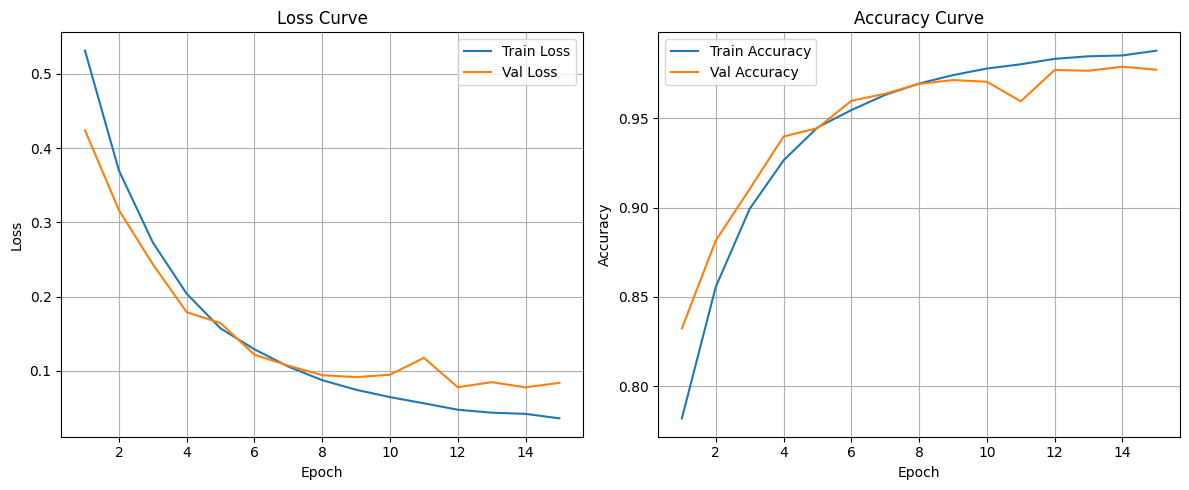

In [9]:
import matplotlib.pyplot as plt

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


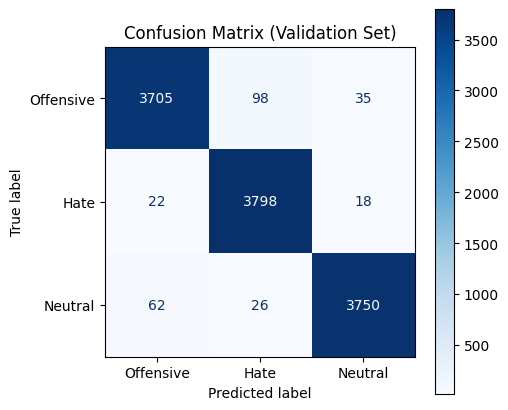

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(val_true, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Offensive", "Hate", "Neutral"])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.show()
